In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [52]:
# tells me if the column is numeric or categorical
def _get_column_type(df, col):
    if pd.api.types.is_numeric_dtype(df[col]):
        return "numeric"
    else:
        return "categorical"

# tells me the percentage of missing values in a column
def _missing_ratio(df, col):
    return df[col].isna().mean() * 100

# decides the imputation strategy for the column
def _auto_strategy(df, col):
    col_type = _get_column_type(df, col)
    missing_ratio = _missing_ratio(df, col)

    if col_type == "numeric":
        if missing_ratio < 10:
            return "mean"
        elif missing_ratio < 30:
            return "knn"
        else:
            return "random_forest"
    else:
        if missing_ratio < 20:
            return "mode"
        else:
            return "random_forest"

In [53]:
# this is the function which uses statistical methods to impute missing values
def _simple_imputer(df, col, strategy="mean"):
    imp = None

    if strategy == "mode":
        strategy = "most_frequent"

    if strategy in ["mean", "median", "most_frequent"]:
        imp = SimpleImputer(strategy=strategy)
    elif strategy == "knn":
        imp = KNNImputer(n_neighbors=5)

    # For KNN, we need all numeric columns
    if strategy == "knn":
        # KNN-imputer requires multiple columns, so we run it over all numeric features
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = imp.fit_transform(df[numeric_cols])
    else:
        df[[col]] = imp.fit_transform(df[[col]])

    return df

In [54]:
# this is the class which uses ml models to impute missing values
def _ml_imputer(df, col, model_type="random_forest"):
    df_non_missing = df[df[col].notna()]
    df_missing = df[df[col].isna()]
    col_type = _get_column_type(df, col)

    if df_missing.empty:
        return df

    X_train = df_non_missing.drop(columns=[col])
    y_train = df_non_missing[col]
    X_pred = df_missing.drop(columns=[col])

    # Separate numeric and categorical features
    numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    categorical_features = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

    # Preprocessing: impute + encode
    numeric_transformer = SimpleImputer(strategy="mean")
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # Choose model
    if col_type == "numeric":
        if model_type == "linear_regression":
            model = LinearRegression()
        elif model_type == "random_forest":
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_type == "mlp":
            model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
        else:
            raise ValueError("Unsupported numeric model type.")
    else:
        if model_type == "logistic_regression":
            model = LogisticRegression(max_iter=200)
        elif model_type == "random_forest":
            model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model_type == "mlp":
            model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
        else:
            raise ValueError("Unsupported categorical model type.")

    # Build pipeline (preprocessing + model)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    # Handle categorical targets separately
    encoder = None
    if col_type == "categorical":
        encoder = LabelEncoder()
        y_train = encoder.fit_transform(y_train.astype(str))

    # Fit and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_pred)

    # Decode categorical predictions
    if encoder is not None:
        y_pred = encoder.inverse_transform(np.round(y_pred).astype(int))

    df.loc[df[col].isna(), col] = y_pred
    return df


In [55]:
def universal_imputer(df, model="auto", columns=None, verbose=True):
    """
    Universal Imputer: performs missing value imputation using statistical, KNN, or ML-based methods.
    """

    df = df.copy()
    imputers_used = {}

    # Step 1: Identify columns to impute
    if columns is None:
        columns = [col for col in df.columns if df[col].isna().any()]

    if verbose:
        print(f"🔍 Columns to impute: {columns}\n")

    # Step 2: Iterate over columns
    for col in columns:
        col_type = _get_column_type(df, col)
        missing_ratio = _missing_ratio(df, col)

        # Decide method
        if model == "auto":
            chosen_model = _auto_strategy(df, col)
        else:
            chosen_model = model

        if verbose:
            print(f"➡️ Imputing '{col}' ({col_type}, missing: {missing_ratio:.2f}%) using '{chosen_model}'")

        # Apply imputation
        if chosen_model in ["mean", "median", "mode", "most_frequent", "knn"]:
            df = _simple_imputer(df, col, chosen_model)
        else:
            df = _ml_imputer(df, col, chosen_model)

        imputers_used[col] = chosen_model

    if verbose:
        print("\n✅ Imputation complete!")
        print(pd.Series(imputers_used, name="Strategy Used"))

    return df


In [56]:
data = {
    "age": [25, np.nan, 35, 40, np.nan, 28],
    "salary": [50000, 60000, np.nan, 80000, 75000, np.nan],
    "gender": ["M", "F", "F", np.nan, "M", "F"]
}

df_test = pd.DataFrame(data)
print("Before Imputation:\n", df_test)

df_imputed = universal_imputer(df_test, model="auto")
print("\nAfter Imputation:\n", df_imputed)


Before Imputation:
     age   salary gender
0  25.0  50000.0      M
1   NaN  60000.0      F
2  35.0      NaN      F
3  40.0  80000.0    NaN
4   NaN  75000.0      M
5  28.0      NaN      F
🔍 Columns to impute: ['age', 'salary', 'gender']

➡️ Imputing 'age' (numeric, missing: 33.33%) using 'random_forest'
➡️ Imputing 'salary' (numeric, missing: 33.33%) using 'random_forest'
➡️ Imputing 'gender' (categorical, missing: 16.67%) using 'mode'

✅ Imputation complete!
age       random_forest
salary    random_forest
gender             mode
Name: Strategy Used, dtype: object

After Imputation:
          age   salary gender
0  25.000000  50000.0      M
1  31.312500  60000.0      F
2  35.000000  70700.0      F
3  40.000000  80000.0      F
4  34.350833  75000.0      M
5  28.000000  56900.0      F


In [57]:
df_test

,age,salary,gender
0,25.0,50000.0,M
1,NaN,60000.0,F
2,35.0,NaN,F
3,40.0,80000.0,NaN
4,NaN,75000.0,M
5,28.0,NaN,F


In [58]:
df_imputed

,age,salary,gender
0,25.000000,50000.0,M
1,31.312500,60000.0,F
2,35.000000,70700.0,F
3,40.000000,80000.0,F
4,34.350833,75000.0,M
5,28.000000,56900.0,F


In [59]:
%pip install ace_tools

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [61]:
data = load_diabetes(as_frame=True)
df_real = data.frame.copy()

In [62]:
df_real

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


In [63]:
np.random.seed(42)
df_missing = df_real.copy()
for col in df_missing.columns:
    mask = np.random.rand(len(df_missing)) < 0.1
    df_missing.loc[mask, col] = np.nan

In [64]:
true_values = df_real.copy()

In [65]:
df_imputed = universal_imputer(df_missing, model="auto", verbose=True)

🔍 Columns to impute: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']

➡️ Imputing 'age' (numeric, missing: 12.90%) using 'knn'
➡️ Imputing 'sex' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 'bmi' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 'bp' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's1' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's2' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's3' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's4' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's5' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 's6' (numeric, missing: 0.00%) using 'mean'
➡️ Imputing 'target' (numeric, missing: 0.00%) using 'mean'

✅ Imputation complete!
age        knn
sex       mean
bmi       mean
bp        mean
s1        mean
s2        mean
s3        mean
s4        mean
s5        mean
s6        mean
target    mean
Name: Strategy Used, dtype: object


In [66]:
mse_scores, mae_scores, rmae_scores = {}, {}, {}
for col in df_real.columns:
    mask = df_missing[col].isna()
    if mask.sum() > 0:
        mse = mean_squared_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
        mae = mean_absolute_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
        mean_val = np.mean(np.abs(true_values[col])) if np.mean(np.abs(true_values[col])) != 0 else 1e-9
        rmae = mae / mean_val

        mse_scores[col] = mse
        mae_scores[col] = mae
        rmae_scores[col] = rmae

metrics_df = pd.DataFrame({"MSE": mse_scores, "MAE": mae_scores, "RMAE": rmae_scores}).sort_values("RMAE")

In [67]:
print("📊 Imputation Performance (Diabetes Dataset):\n")
print(metrics_df.round(6))

📊 Imputation Performance (Diabetes Dataset):

                MSE        MAE      RMAE
target  4227.556757  52.086486  0.342374
s3         0.000981   0.025491  0.679449
s4         0.001249   0.026467  0.713339
s5         0.001309   0.029051  0.750031
bmi        0.001402   0.029777  0.776288
s1         0.001437   0.029714  0.795212
s6         0.001758   0.032022  0.864518
s2         0.001488   0.032583  0.869164
age        0.002065   0.037766  0.961085
sex        0.002841   0.048664  1.025167
bp         0.002730   0.044352  1.129064


Text(0.5, 0.98, 'Auto Imputation Performance (Diabetes Dataset)')

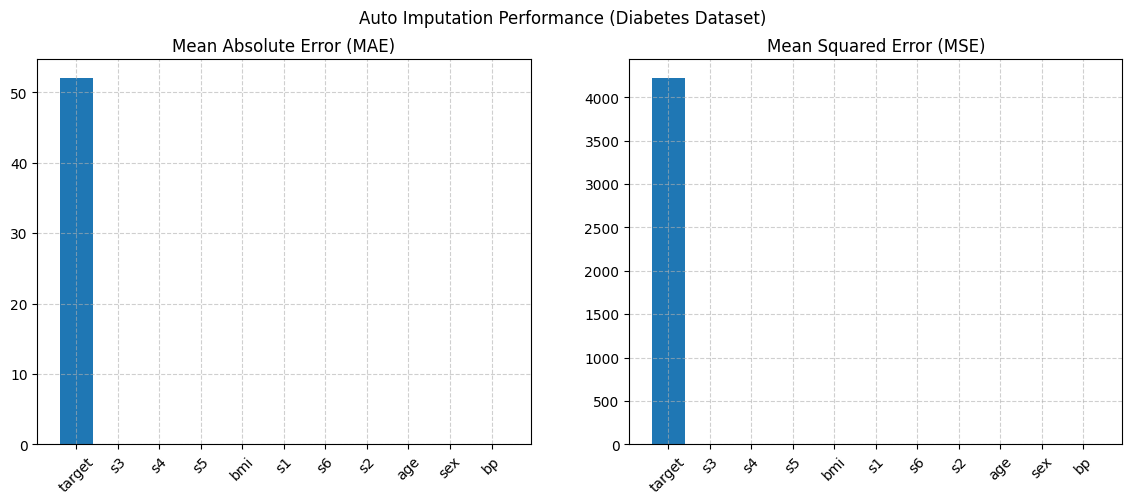

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(metrics_df.index, metrics_df["MAE"])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].bar(metrics_df.index, metrics_df["MSE"])
axes[1].set_title("Mean Squared Error (MSE)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Auto Imputation Performance (Diabetes Dataset)")

📊 Imputation Performance (Without Target Column):

          MSE       MAE      RMAE
s3   0.000645  0.018720  0.498974
s2   0.000643  0.018728  0.499573
s1   0.000783  0.019170  0.513013
s4   0.000886  0.020609  0.555455
s5   0.001138  0.027760  0.716688
bmi  0.001541  0.029701  0.774305
sex  0.002362  0.040637  0.856067
age  0.001959  0.035471  0.902700
s6   0.002103  0.034417  0.929174
bp   0.002437  0.040358  1.027393


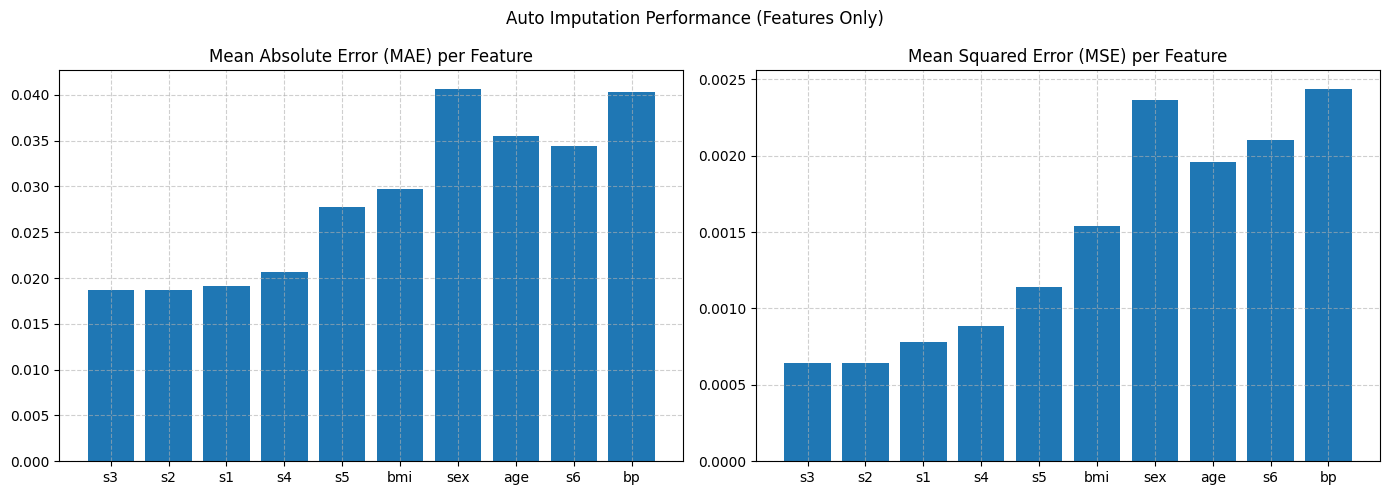

In [69]:
# 🧪 Re-run Evaluation Without Target Column

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---- Assume universal_imputer and helper functions are already defined above ----

# Load dataset (exclude target)
data = load_diabetes(as_frame=True)
df_real = data.frame.copy()
features = df_real.drop(columns=["target"])  # Exclude target
target = df_real["target"]

# Introduce missing values (10% random per column)
np.random.seed(42)
df_missing = features.copy()
for col in df_missing.columns:
    mask = np.random.rand(len(df_missing)) < 0.1
    df_missing.loc[mask, col] = np.nan

# Backup true data
true_values = features.copy()

# Apply auto imputer
df_imputed = universal_imputer(df_missing, model="auto", verbose=False)

# Evaluate metrics (MSE, MAE, RMAE)
mse_scores, mae_scores, rmae_scores = {}, {}, {}
for col in features.columns:
    mask = df_missing[col].isna()
    if mask.sum() > 0:
        mse = mean_squared_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
        mae = mean_absolute_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
        mean_val = np.mean(np.abs(true_values[col])) if np.mean(np.abs(true_values[col])) != 0 else 1e-9
        rmae = mae / mean_val

        mse_scores[col] = mse
        mae_scores[col] = mae
        rmae_scores[col] = rmae

metrics_df = pd.DataFrame({"MSE": mse_scores, "MAE": mae_scores, "RMAE": rmae_scores}).sort_values("RMAE")

# ✅ Show metrics table
print("📊 Imputation Performance (Without Target Column):\n")
print(metrics_df.round(6))

# --- Visualizations ---

# MAE and MSE Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(metrics_df.index, metrics_df["MAE"])
axes[0].set_title("Mean Absolute Error (MAE) per Feature")
axes[0].tick_params(axis='x',)
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].bar(metrics_df.index, metrics_df["MSE"])
axes[1].set_title("Mean Squared Error (MSE) per Feature")
axes[1].tick_params(axis='x',)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Auto Imputation Performance (Features Only)")
plt.tight_layout()
plt.show()


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def benchmark_imputer(dataset_loader, dataset_name=None, missing_fraction=0.1):
    """
    Benchmark universal_imputer on a given sklearn dataset loader function.
    Shows MAE, MSE, RMAE plots for all features.
    """
    # Load dataset
    data = dataset_loader(as_frame=True)
    df_real = data.frame.copy()
    
    # Auto-detect target column (if any)
    target_col = "target" if "target" in df_real.columns else None
    if target_col:
        df_real = df_real.drop(columns=[target_col])
    
    # Introduce random missingness
    np.random.seed(42)
    df_missing = df_real.copy()
    for col in df_missing.columns:
        mask = np.random.rand(len(df_missing)) < missing_fraction
        df_missing.loc[mask, col] = np.nan
    
    # Keep true reference
    true_values = df_real.copy()

    # Apply universal imputer
    df_imputed = universal_imputer(df_missing, model="auto", verbose=False)
    
    # Evaluate metrics
    mse_scores, mae_scores, rmae_scores = {}, {}, {}
    for col in df_real.columns:
        mask = df_missing[col].isna()
        if mask.sum() > 0:
            mse = mean_squared_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
            mae = mean_absolute_error(true_values.loc[mask, col], df_imputed.loc[mask, col])
            mean_val = np.mean(np.abs(true_values[col])) if np.mean(np.abs(true_values[col])) != 0 else 1e-9
            rmae = mae / mean_val

            mse_scores[col] = mse
            mae_scores[col] = mae
            rmae_scores[col] = rmae
    
    metrics_df = pd.DataFrame({"MSE": mse_scores, "MAE": mae_scores, "RMAE": rmae_scores}).sort_values("RMAE")
    
    # --- Visualization ---
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_df.index, metrics_df["MAE"])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Mean Absolute Error (Auto Imputation) — {dataset_name or dataset_loader.__name__}")
    plt.xlabel("Feature")
    plt.ylabel("MAE")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return metrics_df.round(6)



🧪 Running Imputer Benchmark on Diabetes Dataset...



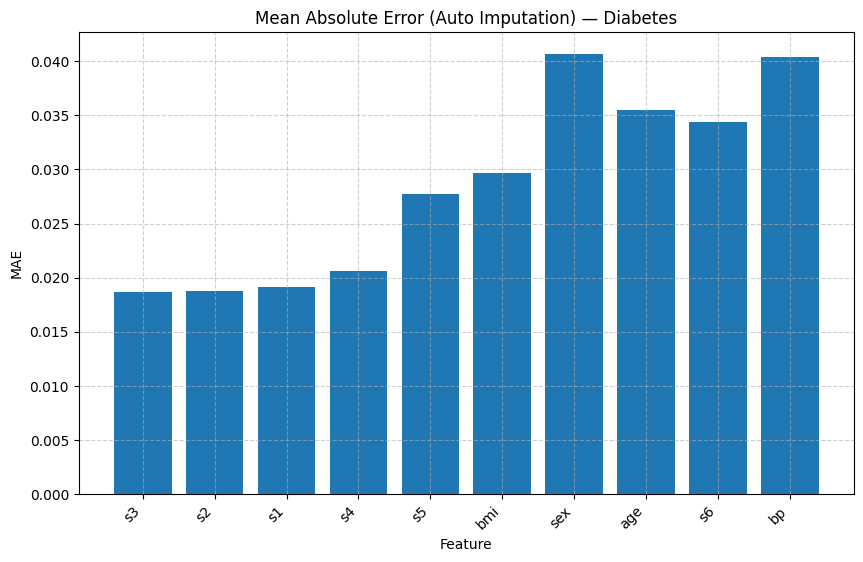

          MSE       MAE      RMAE
s3   0.000645  0.018720  0.498974
s2   0.000643  0.018728  0.499573
s1   0.000783  0.019170  0.513013
s4   0.000886  0.020609  0.555455
s5   0.001138  0.027760  0.716688
bmi  0.001541  0.029701  0.774305
sex  0.002362  0.040637  0.856067
age  0.001959  0.035471  0.902700
s6   0.002103  0.034417  0.929174
bp   0.002437  0.040358  1.027393
--------------------------------------------------------------------------------

🧪 Running Imputer Benchmark on Wine Dataset...



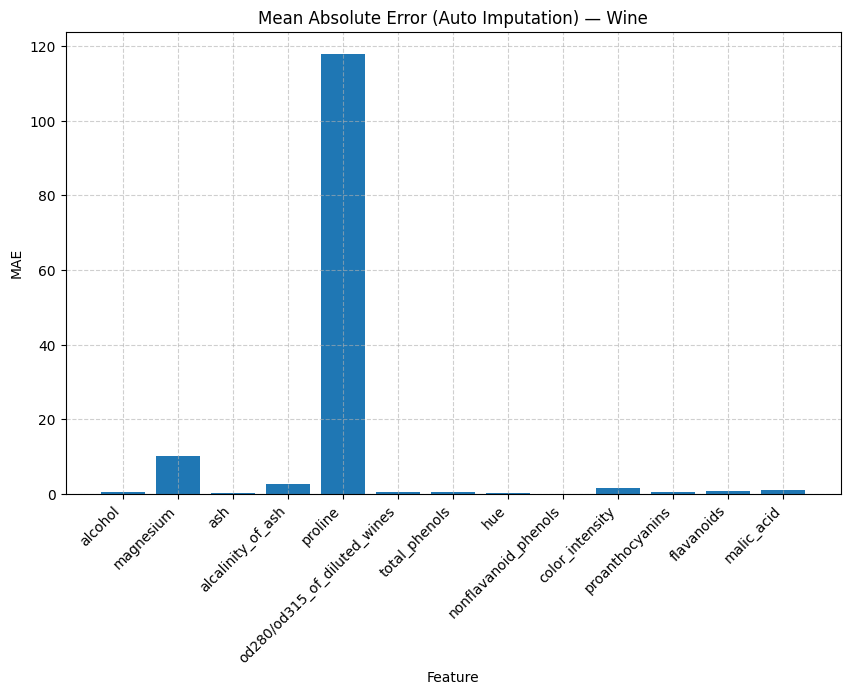

                                       MSE         MAE      RMAE
alcohol                           0.646726    0.681143  0.052393
magnesium                       134.388571   10.114286  0.101405
ash                               0.087434    0.251200  0.106148
alcalinity_of_ash                 9.185829    2.731429  0.140110
proline                       22412.300000  117.877778  0.157824
od280/od315_of_diluted_wines      0.368359    0.516556  0.197786
total_phenols                     0.303465    0.485053  0.211342
hue                               0.058845    0.213000  0.222466
nonflavanoid_phenols              0.014243    0.098909  0.273340
color_intensity                   4.467431    1.674556  0.331065
proanthocyanins                   0.592601    0.578706  0.363760
flavanoids                        1.301786    0.914706  0.450756
malic_acid                        1.482795    1.073727  0.459575
--------------------------------------------------------------------------------

🧪 Runnin

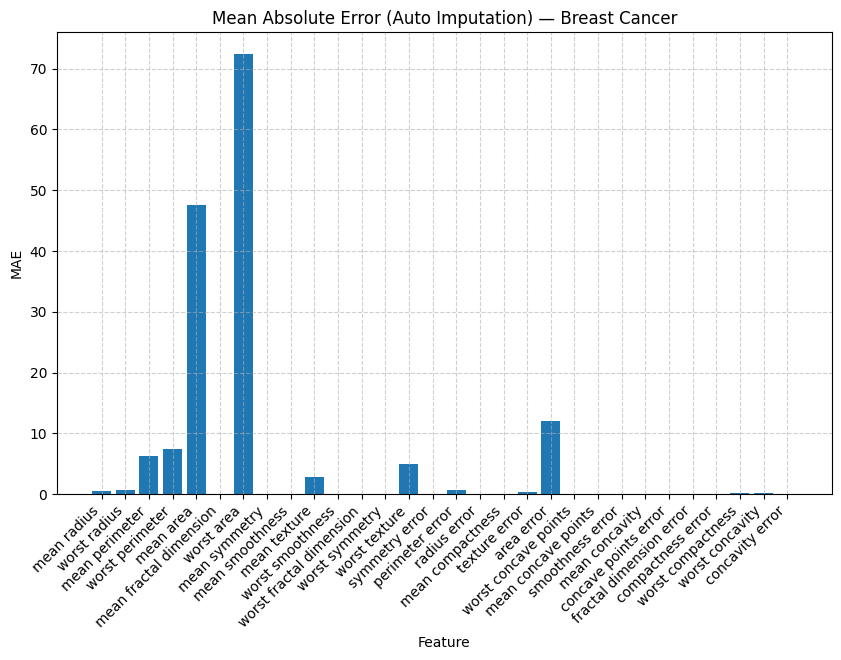

                                  MSE        MAE      RMAE
mean radius                  1.520102   0.568983  0.040275
worst radius                 2.178685   0.722717  0.044422
mean perimeter             209.379763   6.268138  0.068155
worst perimeter            111.873917   7.461898  0.069568
mean area                 7019.564693  47.535333  0.072585
mean fractal dimension       0.000035   0.004753  0.075686
worst area               11110.415702  72.367458  0.082181
mean symmetry                0.000616   0.019738  0.108954
mean smoothness              0.000357   0.014126  0.146592
mean texture                14.595974   2.880113  0.149309
worst smoothness             0.000632   0.019853  0.149985
worst fractal dimension      0.000285   0.012977  0.154585
worst symmetry               0.006141   0.050056  0.172561
worst texture               39.562558   4.912400  0.191314
symmetry error               0.000042   0.004806  0.233934
perimeter error              1.211899   0.673873  0.2351

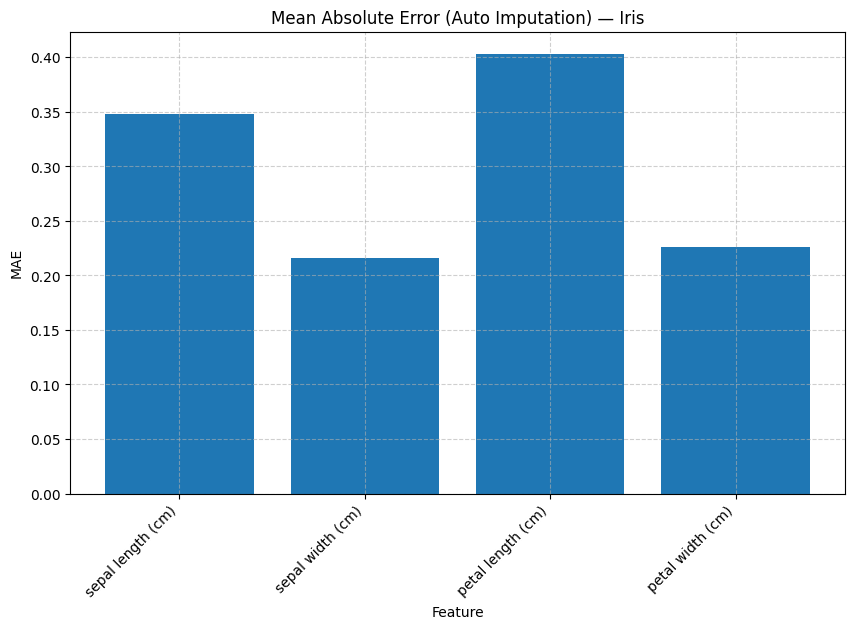

                        MSE       MAE      RMAE
sepal length (cm)  0.174378  0.347778  0.059517
sepal width (cm)   0.073575  0.216250  0.070732
petal length (cm)  0.318567  0.403333  0.107327
petal width (cm)   0.080629  0.225714  0.188200
--------------------------------------------------------------------------------


In [71]:
from sklearn.datasets import load_diabetes, load_wine, load_breast_cancer, load_iris

datasets = [
    (load_diabetes, "Diabetes"),
    (load_wine, "Wine"),
    (load_breast_cancer, "Breast Cancer"),
    (load_iris, "Iris")
]

results = {}

for loader, name in datasets:
    print(f"\n🧪 Running Imputer Benchmark on {name} Dataset...\n")
    results[name] = benchmark_imputer(loader, dataset_name=name)
    print(results[name])
    print("-" * 80)


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def benchmark_imputer_full(dataset_loader, dataset_name=None, missing_fraction=0.1):
    """
    Benchmarks universal_imputer on a given sklearn dataset using both MAE and MAPE.
    """
    # Load dataset
    data = dataset_loader(as_frame=True)
    df_real = data.frame.copy()
    
    # Drop target if present
    target_col = "target" if "target" in df_real.columns else None
    if target_col:
        df_real = df_real.drop(columns=[target_col])
    
    # Introduce random missingness
    np.random.seed(42)
    df_missing = df_real.copy()
    for col in df_missing.columns:
        mask = np.random.rand(len(df_missing)) < missing_fraction
        df_missing.loc[mask, col] = np.nan
    
    # Apply imputer
    df_imputed = universal_imputer(df_missing, model="auto", verbose=False)
    
    # Evaluate MAE and MAPE
    mae_scores, mape_scores = {}, {}
    for col in df_real.columns:
        mask = df_missing[col].isna()
        if mask.sum() > 0:
            y_true = df_real.loc[mask, col]
            y_pred = df_imputed.loc[mask, col]
            mae = mean_absolute_error(y_true, y_pred)
            denom = np.where(y_true == 0, 1e-9, y_true)
            mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100

            mae_scores[col] = mae
            mape_scores[col] = mape
    
    metrics_df = pd.DataFrame({"MAE": mae_scores, "MAPE (%)": mape_scores}).sort_values("MAPE (%)")

    # --- Visualization ---
    fig, axes = plt.subplots(1, 1, figsize=(14, 6))
    
    # MAE Plot
    axes[0].bar(metrics_df.index, metrics_df["MAE"], color="teal")
    axes[0].set_title(f"Mean Absolute Error (MAE) — {dataset_name or dataset_loader.__name__}")
    axes[0].set_xlabel("Feature")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, linestyle="--", alpha=0.6)
    
    # MAPE Plot
    axes[1].bar(metrics_df.index, metrics_df["MAPE (%)"], color="royalblue")
    axes[1].set_title(f"Mean Absolute Percentage Error (MAPE) — {dataset_name or dataset_loader.__name__}")
    axes[1].set_xlabel("Feature")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle="--", alpha=0.6)
    
    plt.suptitle(f"Auto Imputation Performance — {dataset_name or dataset_loader.__name__}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # --- Summary ---
    avg_mae = np.mean(list(mae_scores.values()))
    
    print(f"\n📊 {dataset_name or dataset_loader.__name__} Dataset Summary:")
    print(f"   → Average MAE  : {avg_mae:.6f}")
    
    return metrics_df.round(4)



🧪 Running Full Imputation Benchmark on Diabetes Dataset...



TypeError: 'Axes' object is not subscriptable

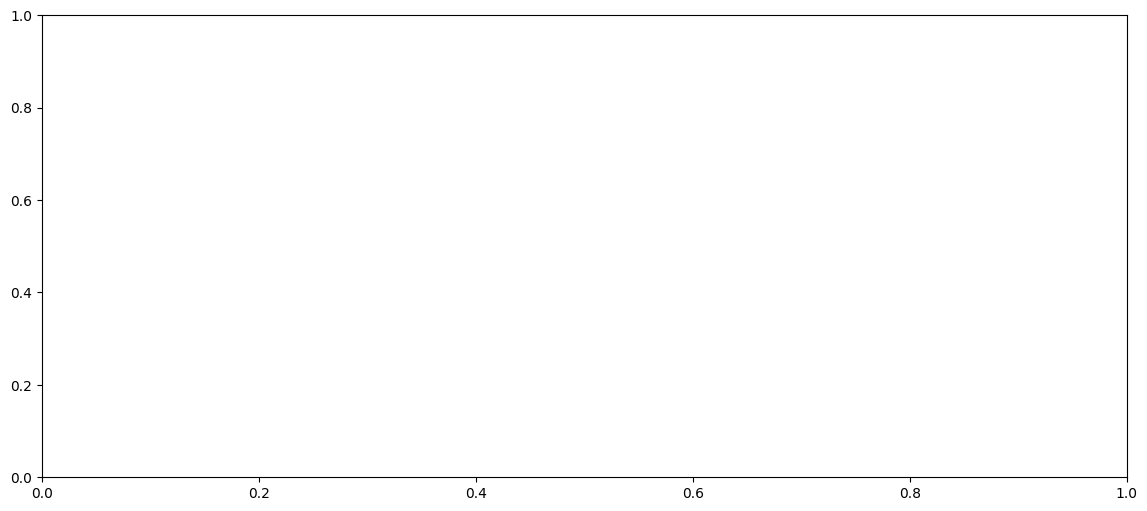

In [73]:
from sklearn.datasets import load_diabetes, load_wine, load_breast_cancer, load_iris

datasets = [
    (load_diabetes, "Diabetes"),
    (load_wine, "Wine"),
    (load_breast_cancer, "Breast Cancer"),
    (load_iris, "Iris")
]

results_full = {}

for loader, name in datasets:
    print(f"\n🧪 Running Full Imputation Benchmark on {name} Dataset...\n")
    results_full[name] = benchmark_imputer_full(loader, dataset_name=name)
    print(results_full[name])
    print("-" * 80)


In [ ]:
import os
from sklearn.datasets import load_diabetes, load_wine, load_breast_cancer, load_iris

# Create a folder to store plots
os.makedirs("imputation_graphs", exist_ok=True)

datasets = [
    (load_diabetes, "Diabetes"),
    (load_wine, "Wine"),
    (load_breast_cancer, "Breast Cancer"),
    (load_iris, "Iris")
]

results_full = {}

for loader, name in datasets:
    print(f"\n🧪 Running Full Imputation Benchmark on {name} Dataset...\n")

    # --- run the benchmark function ---
    data = loader(as_frame=True)
    df_real = data.frame.copy()

    # Drop target if present
    if "target" in df_real.columns:
        df_real = df_real.drop(columns=["target"])

    # Introduce missing values
    np.random.seed(42)
    df_missing = df_real.copy()
    for col in df_missing.columns:
        mask = np.random.rand(len(df_missing)) < 0.1
        df_missing.loc[mask, col] = np.nan

    df_imputed = universal_imputer(df_missing, model="auto", verbose=False)

    # Evaluate metrics
    mae_scores, mape_scores = {}, {}
    for col in df_real.columns:
        mask = df_missing[col].isna()
        if mask.sum() > 0:
            y_true = df_real.loc[mask, col]
            y_pred = df_imputed.loc[mask, col]
            mae = np.mean(np.abs(y_true - y_pred))
            denom = np.where(y_true == 0, 1e-9, y_true)
            mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
            mae_scores[col] = mae
            mape_scores[col] = mape

    metrics_df = pd.DataFrame({"MAE": mae_scores, "MAPE (%)": mape_scores}).sort_values("MAPE (%)")
    results_full[name] = metrics_df

    # --- Create and save plots ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # MAE Plot
    axes[0].bar(metrics_df.index, metrics_df["MAE"], color="teal")
    axes[0].set_title(f"{name} — Mean Absolute Error (MAE)")
    axes[0].set_xlabel("Feature")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, linestyle="--", alpha=0.6)
    
    # MAPE Plot
    axes[1].bar(metrics_df.index, metrics_df["MAPE (%)"], color="royalblue")
    axes[1].set_title(f"{name} — Mean Absolute Percentage Error (MAPE)")
    axes[1].set_xlabel("Feature")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle="--", alpha=0.6)
    
    plt.suptitle(f"Auto Imputation Performance — {name}", fontsize=14)
    plt.tight_layout()

    # Save plot
    save_path = os.path.join("imputation_graphs", f"{name.lower().replace(' ', '_')}_imputation.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"✅ Saved plot as: {save_path}")
    print("-" * 80)



🧪 Running Full Imputation Benchmark on Diabetes Dataset...

✅ Saved plot as: imputation_graphs\diabetes_imputation.png
--------------------------------------------------------------------------------

🧪 Running Full Imputation Benchmark on Wine Dataset...

✅ Saved plot as: imputation_graphs\wine_imputation.png
--------------------------------------------------------------------------------

🧪 Running Full Imputation Benchmark on Breast Cancer Dataset...

✅ Saved plot as: imputation_graphs\breast_cancer_imputation.png
--------------------------------------------------------------------------------

🧪 Running Full Imputation Benchmark on Iris Dataset...

✅ Saved plot as: imputation_graphs\iris_imputation.png
--------------------------------------------------------------------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

eps = 1e-9

def compute_robust_imputation_metrics(df_true, df_missing, df_imputed):
    # 🔹 Align columns across all 3 dataframes
    common_cols = list(set(df_true.columns) & set(df_missing.columns) & set(df_imputed.columns))
    df_true = df_true[common_cols]
    df_missing = df_missing[common_cols]
    df_imputed = df_imputed[common_cols]

    metrics = {}
    for c in common_cols:
        mask = df_missing[c].isna()
        if mask.sum() == 0:
            continue

        y_true = df_true.loc[mask, c].astype(float).to_numpy()
        y_pred = df_imputed.loc[mask, c].astype(float).to_numpy()

        # Basic metrics
        mae = np.mean(np.abs(y_true - y_pred))
        denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
        mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

        denom2 = np.where((np.abs(y_true) + np.abs(y_pred)) < eps, eps, (np.abs(y_true) + np.abs(y_pred)))
        smape = np.mean(2.0 * np.abs(y_true - y_pred) / denom2) * 100.0

        # Robust scale measures
        col_vals = df_true[c].dropna().astype(float)
        if len(col_vals) < 5:
            continue
        q1, q3 = np.percentile(col_vals, [25, 75])
        iqr = max(q3 - q1, eps)
        mad = np.median(np.abs(col_vals - np.median(col_vals)))
        mad = max(mad, eps)

        mae_scaled_iqr = mae / iqr
        mae_scaled_mad = mae / mad

        metrics[c] = {
            "MAE": mae,
            "MAPE (%)": mape,
            "sMAPE (%)": smape,
            "MAE / IQR": mae_scaled_iqr,
            "MAE / MAD": mae_scaled_mad,
            "missing_count": int(mask.sum())
        }

    return pd.DataFrame(metrics).T


def plot_robust_metrics(df_true, df_missing, df_imputed, dataset_name="Dataset"):
    """Compute and plot robust imputation metrics with safeguards."""
    metrics_df = compute_robust_imputation_metrics(df_true, df_missing, df_imputed)

    if metrics_df.empty:
        print(f"⚠️ No imputed columns found for {dataset_name}.")
        return

    metrics_df_sorted = metrics_df.sort_values("MAE / IQR", ascending=False)
    metrics_df_sorted["flag_large_scaled_mae"] = metrics_df_sorted["MAE / IQR"] > 5
    metrics_df_sorted["flag_large_mape"] = metrics_df_sorted["MAPE (%)"] > 30

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    # MAE / IQR
    axes[0].bar(metrics_df_sorted.index, metrics_df_sorted["MAE / IQR"], color="C2")
    axes[0].set_title(f"{dataset_name}: MAE / IQR (scale-normalized)")
    axes[0].set_ylabel("MAE ÷ IQR")
    axes[0].tick_params(axis="x", rotation=45)

    # sMAPE
    axes[1].bar(metrics_df_sorted.index, metrics_df_sorted["sMAPE (%)"], color="C0")
    axes[1].set_title(f"{dataset_name}: sMAPE (%)")
    axes[1].set_ylabel("sMAPE (%)")
    axes[1].tick_params(axis="x", rotation=45)

    # MAPE
    axes[2].bar(metrics_df_sorted.index, metrics_df_sorted["MAPE (%)"], color="royalblue")
    axes[2].set_title(f"{dataset_name}: MAPE (%)")
    axes[2].set_ylabel("MAPE (%)")
    axes[2].tick_params(axis="x", rotation=45)

    plt.suptitle(f"Robust Imputation Evaluation — {dataset_name}", fontsize=14)
    plt.show()

    # --- Summary ---
    avg_scaled_mae = metrics_df["MAE / IQR"].mean()
    avg_mape = metrics_df["MAPE (%)"].mean()
    n_flags = metrics_df_sorted["flag_large_mape"].sum() + metrics_df_sorted["flag_large_scaled_mae"].sum()

    print(f"\n📊 {dataset_name} Summary:")
    print(f"   → Average MAE/IQR: {avg_scaled_mae:.3f}")
    print(f"   → Average MAPE: {avg_mape:.2f}%")
    if n_flags > 0:
        flagged = metrics_df_sorted[metrics_df_sorted['flag_large_mape'] | metrics_df_sorted['flag_large_scaled_mae']].index.tolist()
        print(f"   ⚠️ {len(flagged)} features flagged for inspection: {flagged}")
    else:
        print("   ✅ All features look well-imputed.")

    return metrics_df_sorted